In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/childes_longest_seqs.pickle')

In [6]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,age,dataset,xml_loc,n_words,words_list
0,"[5.762224226229021, 5.572383552919533, 5.43205...","[0.05431588977013128, 0.05373986314362249, 0.0...","[4.823775518081613, 4.861508677698726, 4.84547...","[0.051620718965425236, 0.051774737614866534, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,1409,198,P1Y06M00D,Brown,[/mnt/cube/tsainbur/Projects/github_repos/chil...,1409,"[more, cookie, more, cookie, more, juice, Fras..."
1,"[5.787776843069089, 5.680026585718531, 5.59166...","[0.0597637314432635, 0.05903854294976535, 0.05...","[5.300969361176655, 5.305942181530845, 5.32219...","[0.05726649636867174, 0.05727062416894193, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,825,185,P1Y06M00D,Brown,[/mnt/cube/tsainbur/Projects/github_repos/chil...,825,"[one, two, three, one, two, three, two, one, t..."
2,"[4.954285624802937, 4.576919075782589, 4.46422...","[0.07539348202726595, 0.07394137224790405, 0.0...","[4.146632923151142, 4.182063271009644, 4.21387...","[0.07238924983889114, 0.07258069530944888, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,1.5,774,119,P1Y03M15D,Braunwald,[/mnt/cube/tsainbur/Projects/github_repos/chil...,774,"[Mommy, Mommy, Mommy, Mommy, Mama, Dada, Dada,..."


In [7]:
MI_DF.age_cohort_low.unique()

array([1, 1.5, 2, 2.5, 3], dtype=object)

In [8]:
age_cohorts = [[1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [9]:
MI_DF_list = []
for [ac_low, ac_high] in age_cohorts:
    MI_DF_list.append(MI_DF[MI_DF.age_cohort_low == ac_low][:10])
MI_DF = pd.concat(MI_DF_list)

In [10]:
len(MI_DF)

25

In [11]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [12]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    dist_mask = distances < 100
    distances = distances[dist_mask]
    sig = sig[dist_mask]
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan
    
    
    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))


### plot fits

In [13]:
from matplotlib import gridspec

In [14]:
yoff=-.20

1 1.5


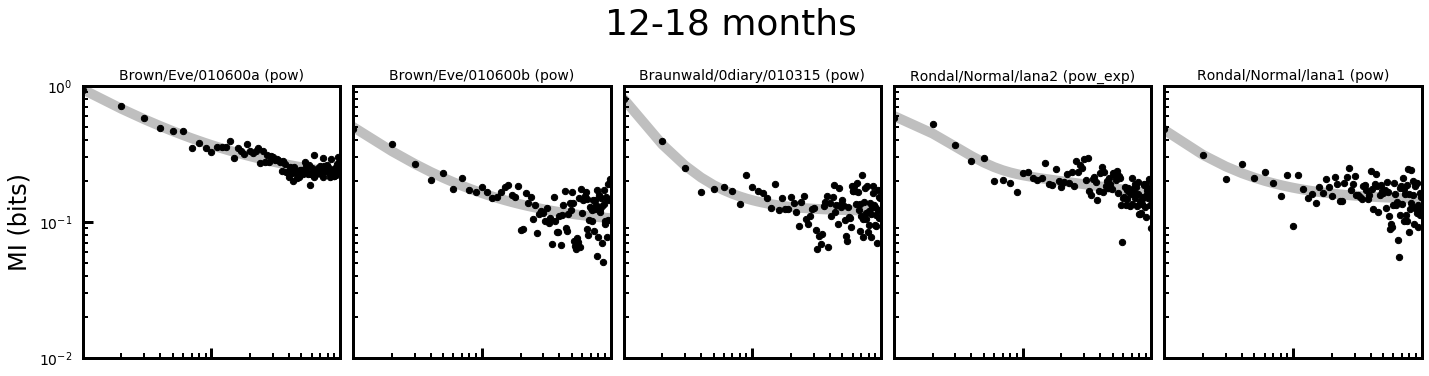

1.5 2


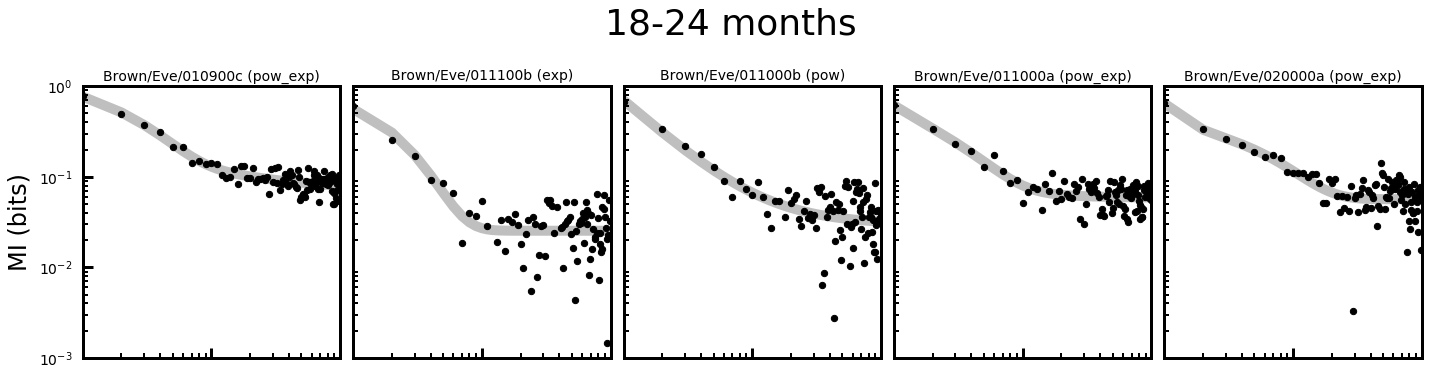

2 2.5


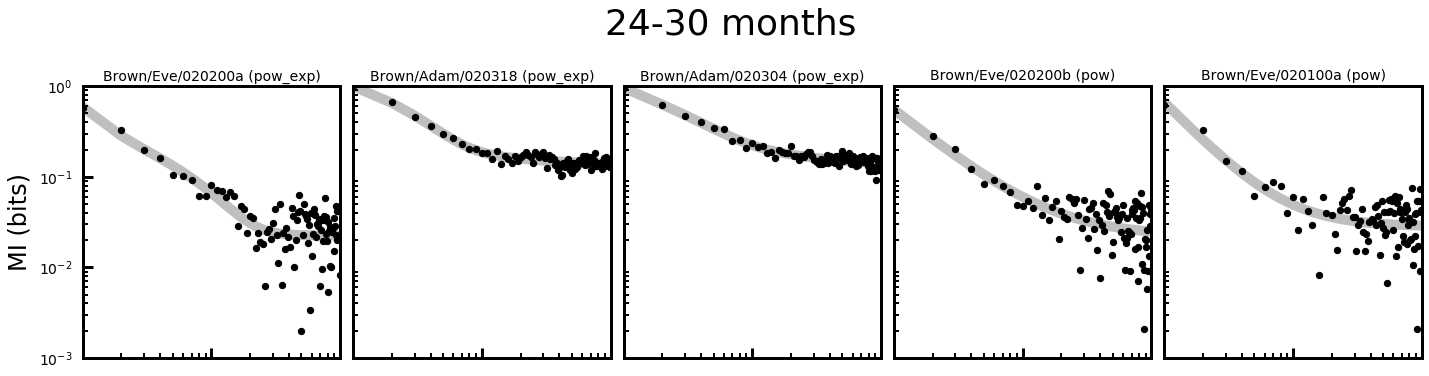

2.5 3


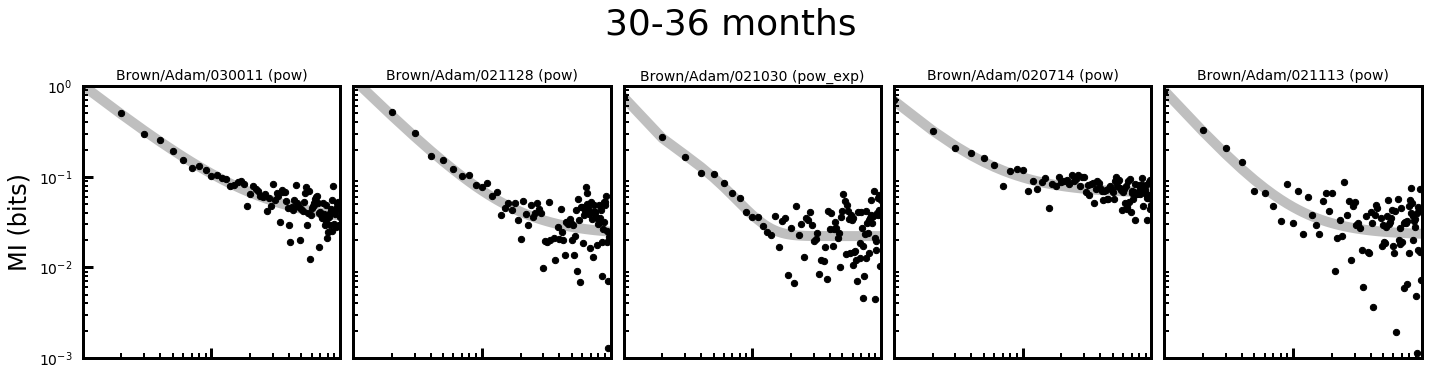

3 20


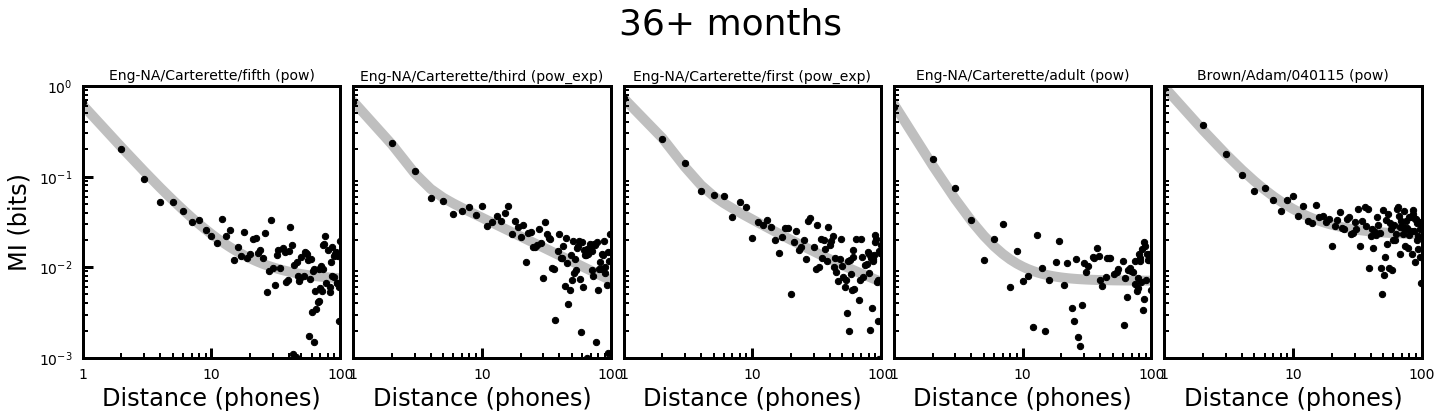

In [26]:
for [ac_low, ac_high] in age_cohorts:
    print(ac_low, ac_high)
    fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(24, 5))
    MI_DF_cohort = MI_DF[MI_DF.age_cohort_low == ac_low]
    for axi, (idx, row) in enumerate(MI_DF_cohort.iterrows()):
        ax = axs.flatten()[axi]

        color = "k"
        sig = np.array(row.MI - row.shuff_MI)
        distances = row.distances
        dist_mask = distances < 100
        
        distances = distances[dist_mask]
        sig = sig[dist_mask]
        
        sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
        sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                            sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

        if axi in [0, 5]:
            ax.set_ylabel("MI (bits)", labelpad=5, fontsize=24)
            ax.yaxis.set_label_coords(yoff, 0.5)

        distances_model = np.logspace(0, np.log10(distances[-1]), base=10, num=1000)

        # plot real data
        ax.scatter(distances, sig, alpha=1, s=40, color=color)

        if row.bestfitmodel == "pow_exp":
            y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)

        elif row.bestfitmodel == "exp":
            y_model = mf.get_y(mf.exp_decay, row.exp_results, distances)

        elif row.bestfitmodel == "pow":
            y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)

        # plot modelled data
        ax.plot(distances, y_model, alpha=0.25, lw=10, color=color)

        
        ax.set_xlim([distances[0], distances[-1]])
        sig_lims[0] = np.log(10e-6)  #
        ax.set_ylim([1e-3, 1])
        ax.tick_params(which="both", direction="in", labelsize=14, pad=10)
        ax.tick_params(which="major", length=10, width=3)
        ax.tick_params(which="minor", length=5, width=2)
        ax.set_xscale("log", basex=10)
        ax.set_yscale("log", basey=10)
        ax.set_xticks([])
        for axis in ["top", "bottom", "left", "right"]:
            ax.spines[axis].set_linewidth(3)
            ax.spines[axis].set_color("k")

        if axi != 0:
            ax.set_yticks([])
    
        if ac_low == 3:
            ax.set_xticks([1,10,100])
            ax.set_xticklabels(['1','10','100'])
            ax.set_xlabel("Distance (phones)", labelpad=5, fontsize=24)
        else:
            ax.set_xticks([1,10,100])
            ax.set_xticklabels([])
        
        ax.set_title(
            "{} ({})".format(
                '/'.join(row.xml_loc[0].split("/")[-3:])[:-4], row.bestfitmodel
            ),
            fontsize=14,
        )
        if ac_low == 1:
            ax.set_ylim([1e-2, 1])
            
            
    fig.subplots_adjust(wspace = 0.05)
    if ac_low == 3:
            fig.suptitle("36+ months", fontsize=36, y=1.1)
    else:
        fig.suptitle("{}-{} months".format(int(ac_low*12), int(12*ac_high)), fontsize=36, y=1.1)
        
    ensure_dir(FIGURE_DIR/ 'mi' / 'indv')
    save_fig(FIGURE_DIR/ 'mi' / 'indv' /('childes_mi_longest_' + str(ac_low) + '_' + str(ac_high)))
    plt.show()